# Kriging with external drift estimation on Jura

## Load Packages

In [150]:
import numpy as np
import pandas as pd
import gstlearn as gl
import gstlearn.plot as gp
import matplotlib.pyplot as plt
np.random.seed(0)


## Load the data set and the prediction grid


We start by loading the data and the prediction grid

In [151]:
# Dataset
jura_all=pd.read_csv("jura/jura_pred.csv")
# Prediction grid
grid = pd.read_csv("jura/jura_grid.csv")
# validation set
jura_val=pd.read_csv("jura/jura_val_loc.csv")
jura_val = jura_val.drop(columns=["seq(1:100)"])

Change the names of the Land Use and Rock in order to be consistent with their names on the grid

In [152]:
## Replace landuse interger code by name
landuse_codes=[1,2,3,4]
landuse_names=["Forest","Pasture","Meadow","Tillage"]
jura_all["Landuse"]=jura_all["Landuse"].replace(landuse_codes,landuse_names)
jura_val["Landuse"]=jura_val["Landuse"].replace(landuse_codes,landuse_names)

## Replace rock type interger code by name
rock_codes=[1,2,3,4,5]
rock_names=["Argovian","Kimmeridgian","Sequanian","Portlandian","Quaternary"]
jura_all["Rock"]=jura_all["Rock"].replace(rock_codes,rock_names)
jura_val["Rock"]=jura_val["Rock"].replace(rock_codes,rock_names)

In [153]:
jura_val

,Xloc,Yloc,Landuse,Rock
0,2.672,3.558,Meadow,Quaternary
1,3.589,4.443,Meadow,Argovian
2,4.010,4.713,Pasture,Argovian
3,2.942,3.137,Pasture,Quaternary
4,1.409,2.748,Meadow,Sequanian
...,...,...,...,...
95,4.248,2.489,Forest,Portlandian
96,3.784,3.677,Forest,Kimmeridgian
97,4.324,2.835,Forest,Kimmeridgian
98,3.859,4.022,Meadow,Sequanian


Build the predictor variables corresponding to Rock with one-hot encoding

In [154]:
from sklearn.preprocessing import OneHotEncoder
# drop the first column for each feature
enc = OneHotEncoder(handle_unknown='ignore' ,drop='first'
                    )
enc.fit(jura_all[["Landuse"]])
#"Forest","Pasture","Meadow","Tillage"
land_indic_jura = pd.DataFrame(enc.transform(jura_all[["Landuse"]]).toarray(),
                               columns = ["Land_Pasture","Land_Meadow","Land_Tillage"])
jura_all = pd.concat([jura_all,land_indic_jura],axis=1)
land_indic_grid = pd.DataFrame(enc.transform(grid[["Landuse"]]).toarray(),
                               columns = ["Land_Pasture","Land_Meadow","Land_Tillage"])
grid = pd.concat([grid,land_indic_grid],axis=1)

In [155]:
# drop the first column for each feature                 )
enc.fit(jura_val[["Landuse"]])
#"Forest","Pasture","Meadow","Tillage"
land_indic_val = pd.DataFrame(enc.transform(jura_val[["Landuse"]]).toarray(),
                               columns = ["Land_Pasture","Land_Meadow","Land_Tillage"])
jura_val = pd.concat([jura_val,land_indic_val],axis=1)

Separate the data set in two sets : the training set and the validation set.
For the project and the Kaggle competition, you should use the full data set for 
the training.
You will submit your prediction on Kaggle for a set of locations on which you will 
only know the locations and the factors of Land Use and Rock at these locations.

In [156]:
jura =jura_all

#val contains the values to predict. For the project, these values will be on Kaggle
#(for other locations) and you won't know them
#You will have the locations and covariables at the unknown locations by the following command :
val_loc =jura_val

In [157]:
val_loc.shape[0]

100

In [158]:
type(val_loc)

pandas.core.frame.DataFrame

## Gstlearn objects

First, we create a gstlearn database containing the data points, and assign the appropriate locators to the variables.

In [159]:
## Create Db
db_jura=gl.Db_fromPanda(jura)

## Set locators
db_jura.setLocators(['Xloc','Yloc'],gl.ELoc.X) # -> Role = Coordinates
db_jura.setLocators(['Co'],gl.ELoc.Z) # -> Role  = Variable of interest
db_jura.setLocators(["Land_*"],gl.ELoc.F) # -> Role = Drift functions

db_jura.display()


Data Base Characteristics

Data Base Summary
-----------------
File is organized as a set of isolated points
Space dimension              = 2
Number of Columns            = 12
Total number of samples      = 259

Variables
---------
Column = 0 - Name = Xloc - Locator = x1
Column = 1 - Name = Yloc - Locator = x2
Column = 2 - Name = Cd - Locator = NA
Column = 3 - Name = Co - Locator = z1
Column = 4 - Name = Cr - Locator = NA
Column = 5 - Name = Cu - Locator = NA
Column = 6 - Name = Ni - Locator = NA
Column = 7 - Name = Pb - Locator = NA
Column = 8 - Name = Zn - Locator = NA
Column = 9 - Name = Land_Pasture - Locator = f1
Column = 10 - Name = Land_Meadow - Locator = f2
Column = 11 - Name = Land_Tillage - Locator = f3


We also create a gstlearn *Grid Database* containing the target grid for the prediction.

In [160]:
### Load grid data into  point database
db_grid_pts=gl.Db_fromPanda(grid)
db_grid_pts.setLocators(["Xloc","Yloc"],gl.ELoc.X)
db_grid_pts.setLocators(["Land_*"],gl.ELoc.F)

### Create empty grid database with right dimensions
db_grid=gl.DbGrid.createCoveringDb(db_jura,dx=[0.05,0.05],margin=[0.2,0.2])

### Migrate variables from point database to grid database
err=gl.migrateMulti(db_grid_pts,db_grid,
                    names=["Land_Pasture","Land_Meadow","Land_Tillage"],
                    namconv=gl.NamingConvention())

### Add selection 
db_grid.addSelection(~np.isnan(db_grid["Land_Pasture"]))## Create DbGrid that covers the Db containing the data
db_grid.setLocators(["Land_*"],gl.ELoc.F)
db_grid.display()


Data Base Grid Characteristics

Data Base Summary
-----------------
File is organized as a regular grid
Space dimension              = 2
Number of Columns            = 6
Total number of samples      = 10545
Number of active samples     = 5895

Grid characteristics:
---------------------
Origin :      0.426     0.380
Mesh   :      0.050     0.050
Number :         95       111

Variables
---------
Column = 0 - Name = x1 - Locator = x1
Column = 1 - Name = x2 - Locator = x2
Column = 2 - Name = Land_Pasture - Locator = f1
Column = 3 - Name = Land_Meadow - Locator = f2
Column = 4 - Name = Land_Tillage - Locator = f3
Column = 5 - Name = NewSel - Locator = sel


Finally, we create a Db containing the validation locations and the value of Cobalt concentrations at those locations.

In [169]:
## Create Db
db_val=gl.Db_fromPanda(val_loc)

## Set locators
db_val.setLocators(['Xloc','Yloc'],gl.ELoc.X) # -> Role = Coordinates
db_val.setLocators(["Land_*"],gl.ELoc.F) # -> Role = Drift functions

db_val.display()


Data Base Characteristics

Data Base Summary
-----------------
File is organized as a set of isolated points
Space dimension              = 2
Number of Columns            = 5
Total number of samples      = 100

Variables
---------
Column = 0 - Name = Xloc - Locator = x1
Column = 1 - Name = Yloc - Locator = x2
Column = 2 - Name = Land_Pasture - Locator = f1
Column = 3 - Name = Land_Meadow - Locator = f2
Column = 4 - Name = Land_Tillage - Locator = f3


## Variography of the residuals

Define a model with a constant mean (*order = 0*) and the number of variables with a f locator the we want to work with (*nfex = 4*)

In [170]:
EDmodel = gl.Model()
EDmodel.setDriftIRF(nfex = 3)

Compute the variogram of the residuals

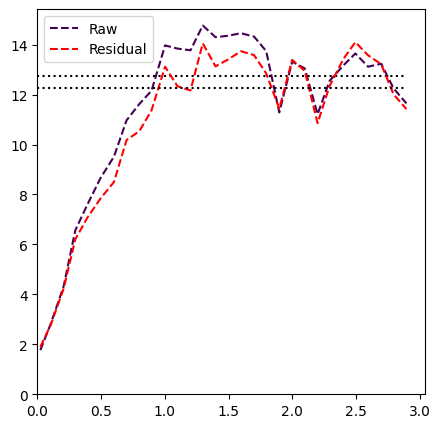

In [171]:
## Create experimental variogram parametrization:
## Setup parameters for a variogram with 30 lags separated by a distance 0.1 (meaning that we compute the variogram at lags h=0.1*i for i=0,...,30),
## and consider a tolerance τ=50% on the distance
varioParamOmni = gl.VarioParam.createOmniDirection(npas=30, dpas=0.1, toldis=0.5)

## Create experimental variogram object with specified parameters
varioRaw = gl.Vario(varioParamOmni) #Raw variable for comparison purpose
varioKED = gl.Vario(varioParamOmni)

## Compute experimental variogram
err = varioRaw.compute(db_jura)
err = varioKED.compute(db_jura,model=EDmodel) #We pass the model to indicate
                                              #that we work on residuals which will
                                              #be computed by the function.

## Plot
ax = gp.varmod(varioRaw,showPairs=False,label = "Raw")
ax = gp.varmod(varioKED,showPairs=False,color = "r",label = "Residual")
ax = plt.legend()

Model fitting

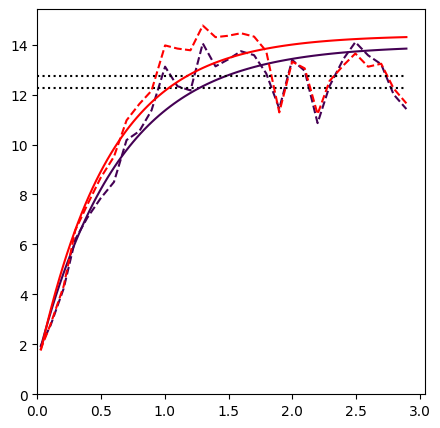

In [172]:
## Create Model objects
fitmodRaw = gl.Model()
fitmodKED = gl.Model()

## set the drift within the model
fitmodRaw.setDriftIRF(order = 0)
fitmodKED.setDriftIRF(order = 0, nfex = 3)

## Fit model on experimental variogram
err = fitmodRaw.fit(varioRaw, types = [gl.ECov.NUGGET, gl.ECov.EXPONENTIAL])
err = fitmodKED.fit(varioKED, types = [gl.ECov.NUGGET, gl.ECov.EXPONENTIAL])

## Plot
gp.varmod(varioKED, fitmodKED)
gp.varmod(varioRaw, fitmodRaw,color="r")
plt.show()

## Kriging with external Drift

The *kriging* function is called to perform the kriging with external drift

In [173]:
## Set the neighborhood
uniqueNeigh = gl.NeighUnique.create()

## Remove variables starting with a given prefix (-> Results from previous runs)
db_grid.deleteColumns(["KED*"])
db_grid.deleteColumns(["OK*"])

## Compute kriging
err = gl.kriging(dbin=db_jura, dbout=db_grid, model=fitmodKED, 
              neigh=uniqueNeigh,
              flag_est=True, flag_std=True, flag_varz=False, ## To compute the predictor and its standard-deviation, but not its variance
              namconv=gl.NamingConvention("KED") ## Prefix that will be used to identify the results in the output database
              )

## Compute ordinary kriging for comparison
err = gl.kriging(dbin=db_jura, dbout=db_grid, model=fitmodRaw, 
              neigh=uniqueNeigh,
              flag_est=True, flag_std=True, flag_varz=False, ## To compute the predictor and its standard-deviation, but not its variance
              namconv=gl.NamingConvention("OK") ## Prefix that will be used to identify the results in the output database
              )
## Display database
db_grid.display()


Data Base Grid Characteristics

Data Base Summary
-----------------
File is organized as a regular grid
Space dimension              = 2
Number of Columns            = 10
Total number of samples      = 10545
Number of active samples     = 5895

Grid characteristics:
---------------------
Origin :      0.426     0.380
Mesh   :      0.050     0.050
Number :         95       111

Variables
---------
Column = 0 - Name = x1 - Locator = x1
Column = 1 - Name = x2 - Locator = x2
Column = 2 - Name = Land_Pasture - Locator = f1
Column = 3 - Name = Land_Meadow - Locator = f2
Column = 4 - Name = Land_Tillage - Locator = f3
Column = 5 - Name = NewSel - Locator = sel
Column = 6 - Name = KED.Co.estim - Locator = NA
Column = 7 - Name = KED.Co.stdev - Locator = NA
Column = 8 - Name = OK.Co.estim - Locator = z1
Column = 9 - Name = OK.Co.stdev - Locator = NA


We can ask for the regression coefficients using *regression*.

In [174]:
regResults = gl.regression(db_jura, nameResp="Co",  model=fitmodKED, mode=2)
regResults.display

<bound method AStringable.display of 
Linear Regression
-----------------
- Calculated on 259 active values
- Explanatory Variable #1 = 7.69455
- Explanatory Variable #2 = 1.69932
- Explanatory Variable #3 = 2.36974
- Explanatory Variable #4 = 0.677455
- Initial variance        = 12.7387
- Variance of residuals   = 12.2618
>

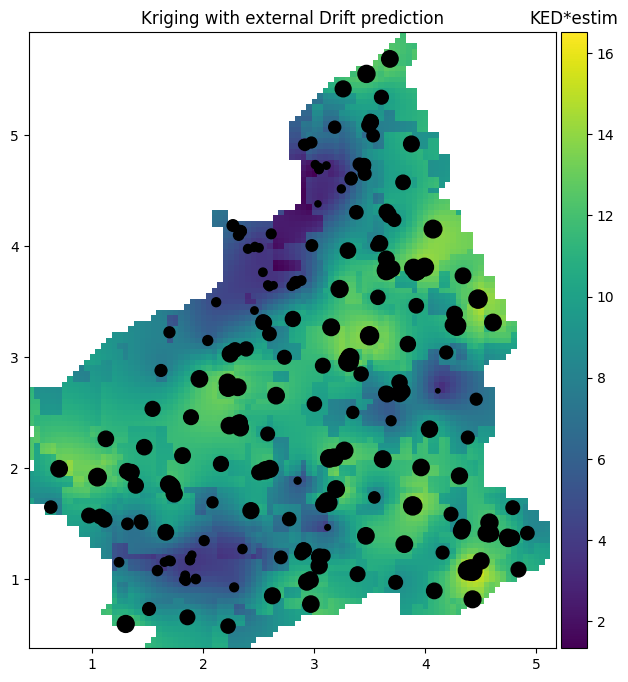

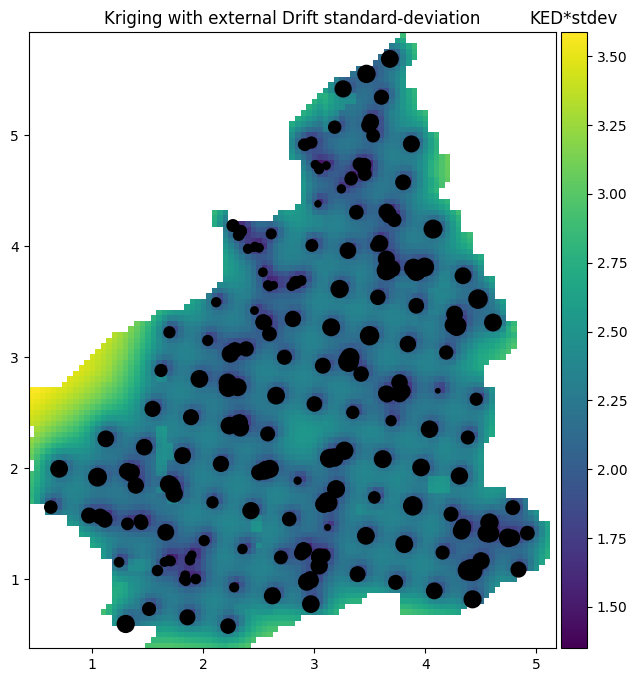

In [175]:
## Plot prediction
fig, ax = gp.initGeographic()
ax.raster(db_grid, name="KED*estim",flagLegend=True)
ax.symbol(db_jura, c='black')
ax.decoration(title="Kriging with external Drift prediction")
plt.show()

## Plot kriging standard-deviation
fig, ax = gp.initGeographic()
ax.raster(db_grid, name="KED*stdev",flagLegend=True)
ax.symbol(db_jura, c='black')
ax.decoration(title="Kriging with external Drift standard-deviation")
plt.show()

Computing the KED prediction at the validation locations and the resulting RMSE can then be done as follows

In [181]:
db_val


Data Base Characteristics

Data Base Summary
-----------------
File is organized as a set of isolated points
Space dimension              = 2
Number of Columns            = 9
Total number of samples      = 100

Variables
---------
Column = 0 - Name = Xloc - Locator = x1
Column = 1 - Name = Yloc - Locator = x2
Column = 2 - Name = Land_Pasture - Locator = f1
Column = 3 - Name = Land_Meadow - Locator = f2
Column = 4 - Name = Land_Tillage - Locator = f3
Column = 5 - Name = KED.Co.estim - Locator = NA
Column = 6 - Name = KED.Co.stdev - Locator = NA
Column = 7 - Name = OK.Co.estim - Locator = z1
Column = 8 - Name = OK.Co.stdev - Locator = NA

In [ ]:
# Fetch KED predictions
ked_predictions = db_val["KED.Co.estim"]
# Fetch OK predictions
ok_predictions = db_val["OK.Co.estim"]

array([ 5.22687649,  9.84942078, 10.48599517, 11.03309594,  9.14916783,
        6.68858941,  8.41318153,  9.76555182, 11.42012092,  9.3661423 ,
        7.52961557, 10.21575229,  8.68097272,  8.19608297, 11.51477492,
       12.15580727, 11.38239996, 10.7117597 ,  6.82886718,  7.98755822,
       11.8106582 ,  5.68129286, 11.37589787,  4.11097066,  8.12024659,
        6.72661913, 14.18217299, 10.78584121, 10.72278539,  9.76433316,
       10.07949272, 11.42087642,  4.28166851, 11.95570339, 10.09972042,
       11.00781217, 13.21082324,  7.16310719,  8.33272013, 12.54496052,
       10.94658803,  7.98688605, 13.00920053,  4.5453265 ,  9.35770633,
        9.99797422, 12.24220473,  6.87741089, 10.15458754,  9.61903499,
       11.35383928, 11.93150881, 11.29113606,  7.45807081, 10.52177014,
        9.81225703,  7.31694569, 12.55178785,  8.7650163 , 12.40885475,
        9.60347611,  9.65856958, 10.78116144, 11.11566166, 10.41310375,
       11.10984626,  6.52458382,  2.1746155 ,  6.6339869 ,  6.30

In [189]:
# Create the Kaggle submission DataFrame
to_kaggle_ked = pd.DataFrame({
    "V1": range(1, len(ked_predictions) + 1),  # Row numbers starting from 1
    "V2": ked_predictions                     # Predicted values
})

to_kaggle_ok = pd.DataFrame({
    "V1": range(1, len(ok_predictions) + 1),  # Row numbers starting from 1
    "V2": ok_predictions                     # Predicted values
})

In [190]:
# Save to CSV if required
to_kaggle_ked.to_csv("submission/KED_predictions.csv", index=False)
to_kaggle_ok.to_csv("submission/OK_predictions.csv", index=False)
print("Submission file created successfully!")

Submission file created successfully!


## Questions

1. Improve the model by adding other explanatory variables (e.g. Landuse or the interactions Rock*Landuse).
2. Estimate the model parameters by maximum Likelihood.
3. Define and adjust a multivariate model with drift. Compute the associated predictions.